Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312156 entries, 0 to 312155
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CATEGORIE  312156 non-null  object 
 1   DATE       312156 non-null  object 
 2   QUART      312156 non-null  object 
 3   PDQ        312151 non-null  float64
 4   X          259474 non-null  float64
 5   Y          259474 non-null  float64
 6   LONGITUDE  259474 non-null  float64
 7   LATITUDE   259474 non-null  float64
dtypes: float64(5), object(3)
memory usage: 19.1+ MB

Summary Statistics:
                 PDQ              X             Y      LONGITUDE  \
count  312151.000000  259474.000000  2.594740e+05  259474.000000   
mean       26.081823  295782.360252  5.043119e+06     -73.615411   
std        13.974121    6102.031819  6.013949e+03       0.078029   
min         1.000000  268109.610010  5.029291e+06     -73.968954   
25%        15.000000  293891.784007  5.039046

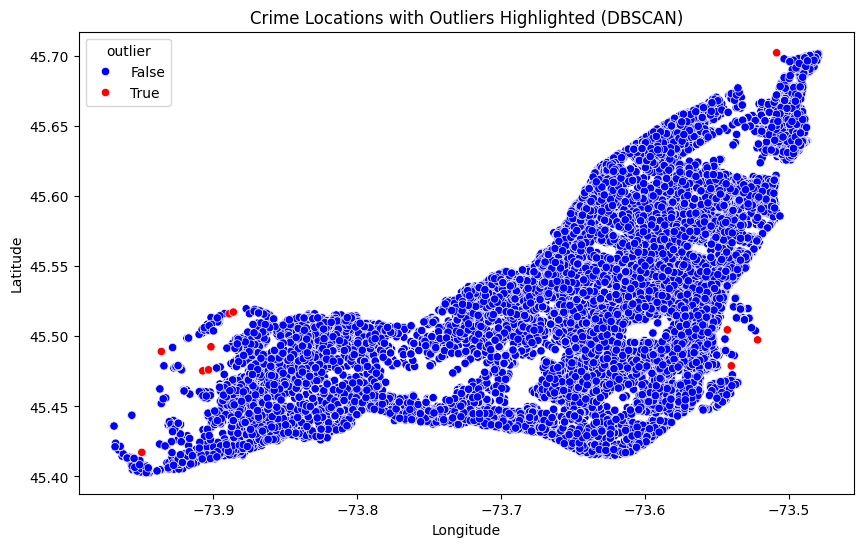


Rare Crime Categories:
Index(['Infractions entrainant la mort'], dtype='object', name='CATEGORIE')


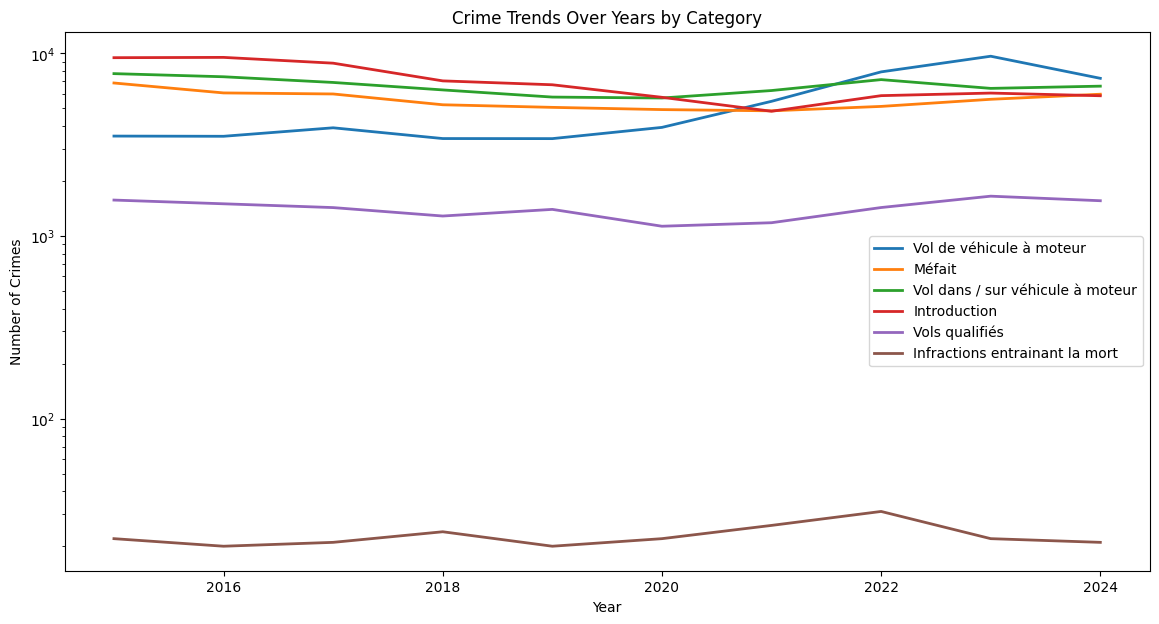


Crime Category Counts:
CATEGORIE
Introduction                        69804
Vol dans / sur véhicule à moteur    66220
Méfait                              55587
Vol de véhicule à moteur            51925
Vols qualifiés                      14120
Infractions entrainant la mort        229
Name: count, dtype: int64


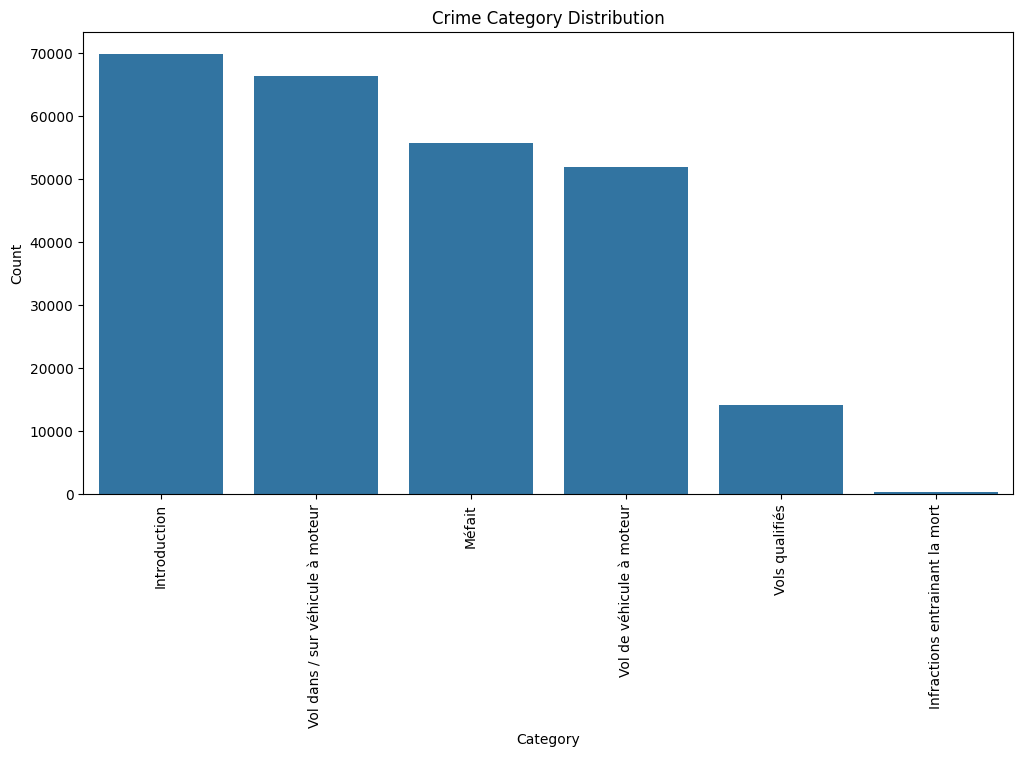


Analysis complete. Outliers saved to 'outliers_detected.csv'.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

# Load the dataset (Replace 'your_file.csv' with the actual file path)
df = pd.read_csv('/content/actes-criminels.csv')

# Display basic information and statistics
print("Dataset Information:")
df.info()
print("\nSummary Statistics:")
print(df.describe())

# Convert DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# 1 - Show all the crime categories
crime_categories = df['CATEGORIE'].unique()
print("\nCrime Categories:")
print(crime_categories)

# 2 - Show the date range covered in the dataset
start_date = df['DATE'].min()
end_date = df['DATE'].max()
print(f"\nCrime Data Covers from {start_date} to {end_date}")

# 3 - Remove rows missing longitude/latitude values
df = df.dropna(subset=['LONGITUDE', 'LATITUDE'])
print("\nRows with missing Longitude/Latitude have been removed.")

# 4 - Remove data from 2025
current_year = pd.Timestamp.now().year
df = df[df['DATE'].dt.year < current_year]
print("\nData from 2025 has been removed to prevent misleading trends.")

# 5 - Detecting Outliers using DBSCAN with adjusted sensitivity
coords = df[['LONGITUDE', 'LATITUDE']].values
db = DBSCAN(eps=0.005, min_samples=5).fit(coords)  # Adjusted `eps` for finer granularity and `min_samples` for lower density threshold
df['outlier'] = db.labels_ == -1  # DBSCAN assigns -1 to noise points
outlier_df = df[df['outlier']]
print(f"\nNumber of Outliers Detected: {outlier_df.shape[0]}")

# Scatter plot to visualize DBSCAN outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='LONGITUDE', y='LATITUDE', hue=df['outlier'], palette={True: 'red', False: 'blue'})
plt.title('Crime Locations with Outliers Highlighted (DBSCAN)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# 6 - Identify Outliers in Crime Categories (Rare Crime Types)
category_counts = df['CATEGORIE'].value_counts()
rare_crimes = category_counts[category_counts < category_counts.quantile(0.05)].index  # Crimes in the bottom 5%
df['rare_crime'] = df['CATEGORIE'].isin(rare_crimes)
print("\nRare Crime Categories:")
print(rare_crimes)

# 7 - Plot crimes over the years with different colors for each type
plt.figure(figsize=(14, 7))
for category in df['CATEGORIE'].unique():
    subset = df[df['CATEGORIE'] == category].groupby(df['DATE'].dt.year).size()
    plt.plot(subset.index, subset.values, label=category, linewidth=2)
plt.legend()
plt.title('Crime Trends Over Years by Category')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.yscale('log')  # Apply log scale to make smaller categories more visible
plt.show()

# Count occurrences by category
print("\nCrime Category Counts:")
print(category_counts)

# Plot category distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=90)
plt.title('Crime Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Save outliers to a CSV file
outlier_df.to_csv('outliers_detected.csv', index=False)

print("\nAnalysis complete. Outliers saved to 'outliers_detected.csv'.")



📊 Overall Crime vs. Fire Incidents Correlation: 0.2436 (p-value: 0.0000)


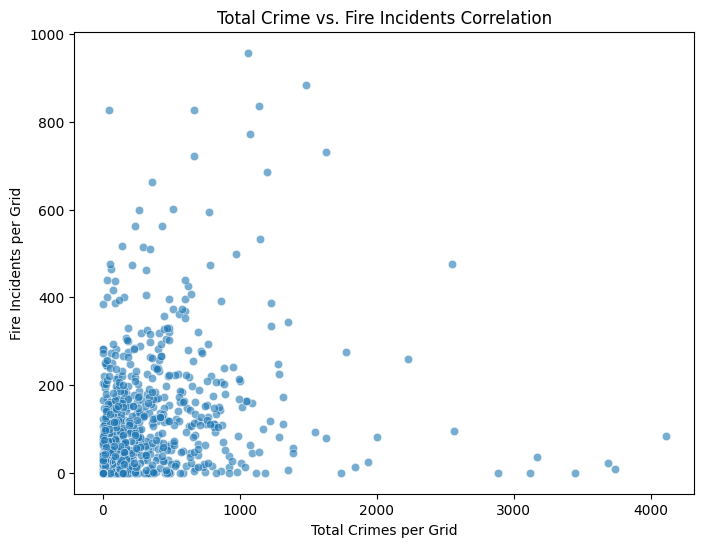

In [14]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.stats import pearsonr

# File Paths
crime_file = "/content/actes-criminels.csv"
fire_file = "/content/incidents-clean.csv"
grid_file = "/content/sqrc_1000 (1).geojson"

# Load Datasets
df_crime = pd.read_csv(crime_file)
df_fires = pd.read_csv(fire_file)
grid_gdf = gpd.read_file(grid_file)

# Convert to GeoDataFrames
df_crime = df_crime.dropna(subset=["LATITUDE", "LONGITUDE"])
df_crime["geometry"] = df_crime.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_crime_gdf = gpd.GeoDataFrame(df_crime, geometry="geometry", crs="EPSG:4326")

df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])
df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Spatial Join: Assign Crimes & Fire Incidents to Grid Squares
crime_with_grid = gpd.sjoin(df_crime_gdf, grid_gdf, how="left", predicate="intersects")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="intersects")

# Aggregate: Total Crimes & Fire Incidents per Grid
crime_total_per_grid = crime_with_grid.groupby("index_right").size().rename("total_crime_count").reset_index()
fire_counts = fires_with_grid.groupby("index_right").size().rename("fire_count").reset_index()

# Merge Crime & Fire Data into Grid
grid_gdf = grid_gdf.merge(crime_total_per_grid, left_index=True, right_on="index_right", how="left")
grid_gdf = grid_gdf.merge(fire_counts, left_index=True, right_on="index_right", how="left")

# Fill NaN values (for grids with no incidents)
grid_gdf.fillna(0, inplace=True)

# Compute Pearson Correlation
correlation, p_value = pearsonr(grid_gdf["total_crime_count"], grid_gdf["fire_count"])
print(f"\n📊 Overall Crime vs. Fire Incidents Correlation: {correlation:.4f} (p-value: {p_value:.4f})")

# Scatter Plot: Total Crimes vs. Fire Incidents
plt.figure(figsize=(8, 6))
sns.scatterplot(x=grid_gdf["total_crime_count"], y=grid_gdf["fire_count"], alpha=0.6)
plt.xlabel("Total Crimes per Grid")
plt.ylabel("Fire Incidents per Grid")
plt.title("Total Crime vs. Fire Incidents Correlation")
plt.show()



📊 Correlation Between Crime Categories and Fire Incidents:

Vol de véhicule à moteur: Correlation = 0.7114, p-value = 0.0000
Méfait: Correlation = 0.9356, p-value = 0.0000
Vols qualifiés: Correlation = 0.8184, p-value = 0.0000
Vol dans / sur véhicule à moteur: Correlation = 0.8141, p-value = 0.0000
Introduction: Correlation = 0.9271, p-value = 0.0000
Infractions entrainant la mort: Correlation = 0.5677, p-value = 0.0000


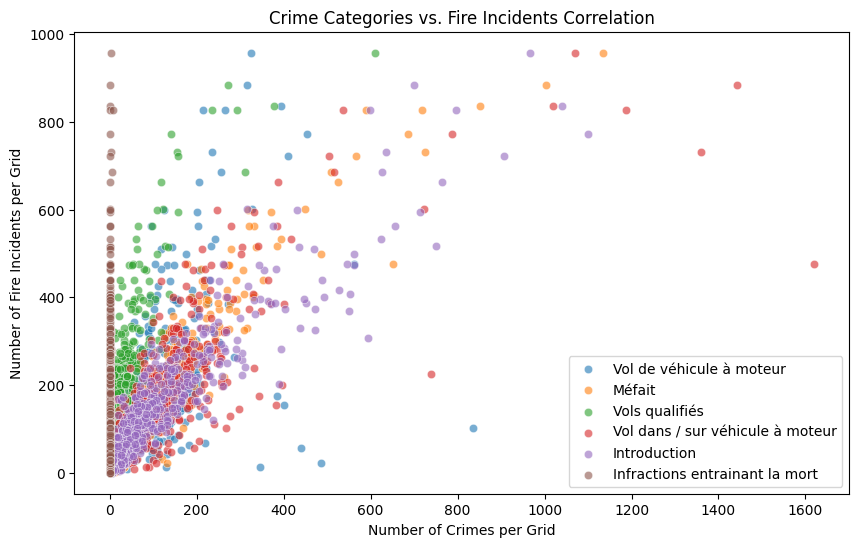

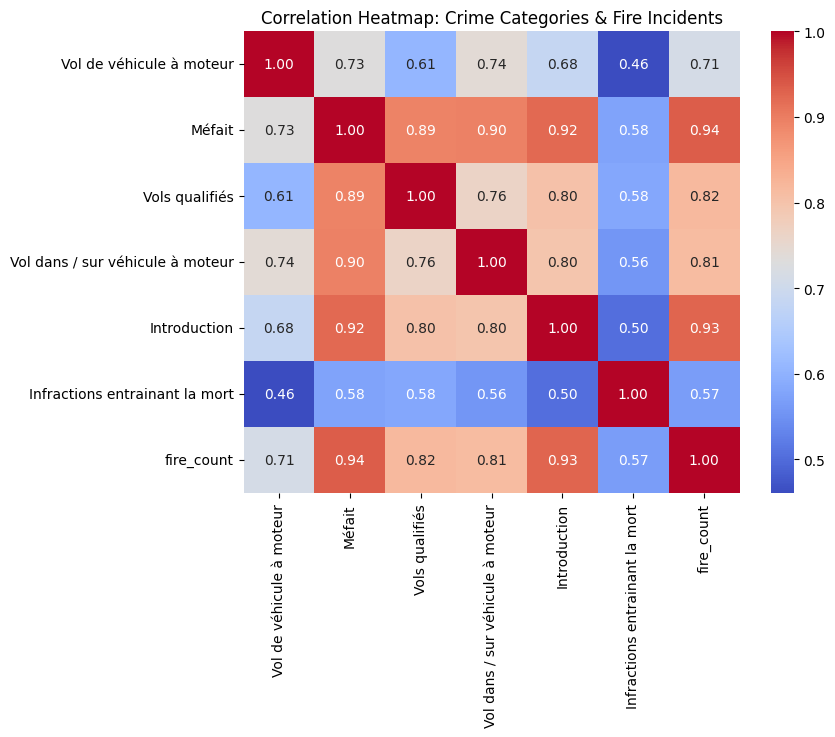

In [15]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.stats import pearsonr
import statsmodels.api as sm

# File Paths
crime_file = "/content/actes-criminels.csv"
fire_file = "/content/incidents-clean.csv"
grid_file = "/content/sqrc_1000 (1).geojson"

# Load Datasets
df_crime = pd.read_csv(crime_file)
df_fires = pd.read_csv(fire_file)
grid_gdf = gpd.read_file(grid_file)

# Convert to GeoDataFrames
df_crime = df_crime.dropna(subset=["LATITUDE", "LONGITUDE"])
df_crime["geometry"] = df_crime.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_crime_gdf = gpd.GeoDataFrame(df_crime, geometry="geometry", crs="EPSG:4326")

df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])
df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Define Crime Categories for Analysis
crime_categories = [
    "Vol de véhicule à moteur",
    "Méfait",
    "Vols qualifiés",
    "Vol dans / sur véhicule à moteur",
    "Introduction",
    "Infractions entrainant la mort"
]

df_filtered_crimes = df_crime_gdf[df_crime_gdf["CATEGORIE"].isin(crime_categories)]

#  Spatial Join: Assign Crimes & Fire Incidents to Grid Squares
crime_with_grid = gpd.sjoin(df_filtered_crimes, grid_gdf, how="left", predicate="intersects")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="intersects")

#  Aggregate Data: Count of Each Crime Type per Grid
crime_counts_per_grid = crime_with_grid.groupby(["index_right", "CATEGORIE"]).size().unstack(fill_value=0)
fire_counts = fires_with_grid.groupby("index_right").size().rename("fire_count").reset_index()

# Merge Crime & Fire Data into Grid
grid_gdf = grid_gdf.merge(crime_counts_per_grid, left_index=True, right_index=True, how="left")
grid_gdf = grid_gdf.merge(fire_counts, left_index=True, right_on="index_right", how="left")

# Fill NaN values (for grids with no incidents)
grid_gdf.fillna(0, inplace=True)

# Compute Pearson Correlation for Each Crime Type
correlation_results = {}
for crime in crime_categories:
    if grid_gdf[crime].sum() > 0:  # Avoid zero-value columns
        correlation, p_value = pearsonr(grid_gdf[crime], grid_gdf["fire_count"])
        correlation_results[crime] = (correlation, p_value)
    else:
        print(f"Warning: No occurrences of '{crime}' found in the dataset. Skipping correlation.")

#  Display Correlation Results
print("\n Correlation Between Crime Categories and Fire Incidents:\n")
for crime, (corr, p) in correlation_results.items():
    print(f"{crime}: Correlation = {corr:.4f}, p-value = {p:.4f}")

#  Scatter Plot: Crime Categories vs. Fire Incidents
plt.figure(figsize=(10, 6))
for crime in correlation_results.keys():  # Only plot crimes that exist
    sns.scatterplot(x=grid_gdf[crime], y=grid_gdf["fire_count"], label=crime, alpha=0.6)

plt.xlabel("Number of Crimes per Grid")
plt.ylabel("Number of Fire Incidents per Grid")
plt.title("Crime Categories vs. Fire Incidents Correlation")
plt.legend()
plt.show()

#  Heatmap: Crime Categories vs. Fire Incidents
plt.figure(figsize=(8, 6))
sns.heatmap(grid_gdf[list(correlation_results.keys()) + ["fire_count"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Crime Categories & Fire Incidents")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


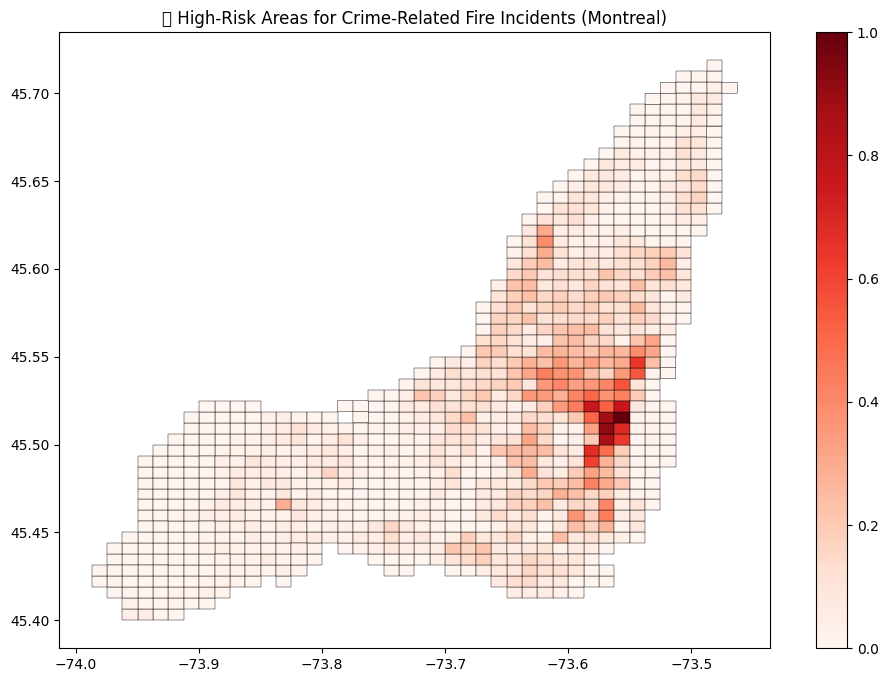

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

# Load Data
crime_file = "/content/actes-criminels.csv"
fire_file = "/content/incidents-clean.csv"
grid_file = "/content/sqrc_1000 (1).geojson"

df_crime = pd.read_csv(crime_file)
df_fires = pd.read_csv(fire_file)
grid_gdf = gpd.read_file(grid_file)

# Convert to GeoDataFrames
df_crime = df_crime.dropna(subset=["LATITUDE", "LONGITUDE"])
df_crime["geometry"] = df_crime.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_crime_gdf = gpd.GeoDataFrame(df_crime, geometry="geometry", crs="EPSG:4326")

df_fires = df_fires.dropna(subset=["LATITUDE", "LONGITUDE"])
df_fires["geometry"] = df_fires.apply(lambda row: Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
df_fires_gdf = gpd.GeoDataFrame(df_fires, geometry="geometry", crs="EPSG:4326")

# Ensure Grid CRS is Correct
grid_gdf = grid_gdf.to_crs("EPSG:4326")

# Define High-Correlation Crimes
high_corr_crimes = ["Méfait", "Introduction", "Vol de véhicule à moteur"]  # These had the highest correlations

df_filtered_crimes = df_crime_gdf[df_crime_gdf["CATEGORIE"].isin(high_corr_crimes)]

# Spatial Join: Assign Crimes & Fire Incidents to Grid Squares
crime_with_grid = gpd.sjoin(df_filtered_crimes, grid_gdf, how="left", predicate="intersects")
fires_with_grid = gpd.sjoin(df_fires_gdf, grid_gdf, how="left", predicate="intersects")

# Aggregate Data: Count of High-Correlation Crimes per Grid
crime_counts_per_grid = crime_with_grid.groupby(["index_right", "CATEGORIE"]).size().unstack(fill_value=0)
fire_counts = fires_with_grid.groupby("index_right").size().rename("fire_count").reset_index()

# Merge Crime & Fire Data into Grid
grid_gdf = grid_gdf.merge(crime_counts_per_grid, left_index=True, right_index=True, how="left")
grid_gdf = grid_gdf.merge(fire_counts, left_index=True, right_on="index_right", how="left")

# Fill NaN values (for grids with no incidents)
grid_gdf.fillna(0, inplace=True)

# Create a "Risk Score" Based on High-Correlation Crimes
grid_gdf["risk_score"] = (
    grid_gdf["Méfait"] * 0.94 +  # Weight crime by correlation strength
    grid_gdf["Introduction"] * 0.93 +
    grid_gdf["Vol de véhicule à moteur"] * 0.71 +
    grid_gdf["fire_count"]  # Include fire counts in risk score
)

#  Normalize the Risk Score (for better visualization)
grid_gdf["risk_score_norm"] = (grid_gdf["risk_score"] - grid_gdf["risk_score"].min()) / (
    grid_gdf["risk_score"].max() - grid_gdf["risk_score"].min()
)

# Map the High-Risk Areas
fig, ax = plt.subplots(figsize=(12, 8))
grid_gdf.plot(column="risk_score_norm", cmap="Reds", linewidth=0.3, edgecolor="black", legend=True, ax=ax)
plt.title("🔥 High-Risk Areas for Crime-Related Fire Incidents (Montreal)")
plt.show()
